In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lasio
import glob
import seaborn
from __future__ import division
import cProfile

%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
l=lasio.read(r'D:\geohack\LAS\5002320005.las') #reads the well log .las file

In [3]:
from pprint import pprint
for curve in l.curves:
    print("%s\t[%s]\t%s\t%s" % (curve.mnemonic, curve.unit, curve.value, curve.descr))

DEPT	[F]		1  DEPTH
CALI	[IN]		2
GR	[GAPI]		3
RHOB	[G/C3]		4
NPHI	[%]		5
DPHI	[%]		6
SP	[MV]		7
LL8	[OHMM]		8
ILD	[OHMM]		9
CILD	[MMHO]		10
DT	[US/F]		11


In [4]:
gr = pd.Series(l['ILD']).fillna(value=0)
depth = pd.Series(l['DEPT']).fillna(value=0)
df = pd.DataFrame()
df['depth'] = l['DEPT']
df['sn'] = l['SN']
df['sp'] = l['SP']
df['ild'] = l['ILD']
df['cild'] = l['CILD']
df['dt'] = l['DT']
df.head()

,depth,sn,sp,ild,cild,dt
0,1260.0,None,NaN,NaN,NaN,NaN
1,1260.5,None,NaN,NaN,NaN,NaN
2,1261.0,None,NaN,NaN,NaN,NaN
3,1261.5,None,NaN,NaN,NaN,NaN
4,1262.0,None,NaN,NaN,NaN,NaN


In [5]:
from __future__ import division
import numpy as np
from scipy.special import gammaln, multigammaln
from scipy.misc import comb
from decorator import decorator

# This makes the code compatible with Python 3
# without causing performance hits on Python 2
try:
    xrange
except NameError:
    xrange = range


try:
    from sselogsumexp import logsumexp
except ImportError:
    from scipy.special import logsumexp
    print("Use scipy logsumexp().")
else:
    print("Use SSE accelerated logsumexp().")


def _dynamic_programming(f, *args, **kwargs):
    if f.data is None:
        f.data = args[0]

    if not np.array_equal(f.data, args[0]):
        f.cache = {}
        f.data = args[0]

    try:
        f.cache[args[1:3]]
    except KeyError:
        f.cache[args[1:3]] = f(*args, **kwargs)
    return f.cache[args[1:3]]

def dynamic_programming(f):
    f.cache = {}
    f.data = None
    return decorator(_dynamic_programming, f)


def offline_changepoint_detection(data, prior_func,
                                  observation_log_likelihood_function,
                                  truncate=-np.inf):
    """Compute the likelihood of changepoints on data.
    Keyword arguments:
    data                                -- the time series data
    prior_func                          -- a function given the likelihood of a changepoint given the distance to the last one
    observation_log_likelihood_function -- a function giving the log likelihood
                                           of a data part
    truncate                            -- the cutoff probability 10^truncate to stop computation for that changepoint log likelihood
    P                                   -- the likelihoods if pre-computed
    """

    n = len(data)
    Q = np.zeros((n,))
    g = np.zeros((n,))
    G = np.zeros((n,))
    P = np.ones((n, n)) * -np.inf

    # save everything in log representation
    for t in range(n):
        g[t] = np.log(prior_func(t))
        if t == 0:
            G[t] = g[t]
        else:
            G[t] = np.logaddexp(G[t-1], g[t])

    P[n-1, n-1] = observation_log_likelihood_function(data, n-1, n)
    Q[n-1] = P[n-1, n-1]

    for t in reversed(range(n-1)):
        P_next_cp = -np.inf  # == log(0)
        for s in range(t, n-1):
            P[t, s] = observation_log_likelihood_function(data, t, s+1)

            # compute recursion
            summand = P[t, s] + Q[s + 1] + g[s + 1 - t]
            P_next_cp = np.logaddexp(P_next_cp, summand)

            # truncate sum to become approx. linear in time (see
            # Fearnhead, 2006, eq. (3))
            if summand - P_next_cp < truncate:
                break

        P[t, n-1] = observation_log_likelihood_function(data, t, n)

        # (1 - G) is numerical stable until G becomes numerically 1
        if G[n-1-t] < -1e-15:  # exp(-1e-15) = .99999...
            antiG = np.log(1 - np.exp(G[n-1-t]))
        else:
            # (1 - G) is approx. -log(G) for G close to 1
            antiG = np.log(-G[n-1-t])

        Q[t] = np.logaddexp(P_next_cp, P[t, n-1] + antiG)

    Pcp = np.ones((n-1, n-1)) * -np.inf
    for t in range(n-1):
        Pcp[0, t] = P[0, t] + Q[t + 1] + g[t] - Q[0]
        if np.isnan(Pcp[0, t]):
            Pcp[0, t] = -np.inf
    for j in range(1, n-1):
        for t in range(j, n-1):
            tmp_cond = Pcp[j-1, j-1:t] + P[j:t+1, t] + Q[t + 1] + g[0:t-j+1] - Q[j:t+1]
            Pcp[j, t] = logsumexp(tmp_cond.astype(np.float32))
            if np.isnan(Pcp[j, t]):
                Pcp[j, t] = -np.inf

    return Q, P, Pcp

@dynamic_programming
def gaussian_obs_log_likelihood(data, t, s):
    s += 1
    n = s - t
    mean = data[t:s].sum(0) / n

    muT = (n * mean) / (1 + n)
    nuT = 1 + n
    alphaT = 1 + n / 2
    betaT = 1 + 0.5 * ((data[t:s] - mean) ** 2).sum(0) + ((n)/(1 + n)) * (mean**2 / 2)
    scale = (betaT*(nuT + 1))/(alphaT * nuT)

    # splitting the PDF of the student distribution up is /much/ faster.
    # (~ factor 20) using sum over for loop is even more worthwhile
    prob = np.sum(np.log(1 + (data[t:s] - muT)**2/(nuT * scale)))
    lgA = gammaln((nuT + 1) / 2) - np.log(np.sqrt(np.pi * nuT * scale)) - gammaln(nuT/2)

    return np.sum(n * lgA - (nuT + 1)/2 * prob)

def ifm_obs_log_likelihood(data, t, s):
    '''Independent Features model from xuan et al'''
    s += 1
    n = s - t
    x = data[t:s]
    if len(x.shape)==2:
        d = x.shape[1]
    else:
        d = 1
        x = np.atleast_2d(x).T

    N0 = d          # weakest prior we can use to retain proper prior
    V0 = np.var(x)
    Vn = V0 + (x**2).sum(0)

    # sum over dimension and return (section 3.1 from Xuan paper):
    return d*( -(n/2)*np.log(np.pi) + (N0/2)*np.log(V0) - \
        gammaln(N0/2) + gammaln((N0+n)/2) ) - \
        ( ((N0+n)/2)*np.log(Vn) ).sum(0)

def fullcov_obs_log_likelihood(data, t, s):
    '''Full Covariance model from xuan et al'''
    s += 1
    n = s - t
    x = data[t:s]
    if len(x.shape)==2:
        dim = x.shape[1]
    else:
        dim = 1
        x = np.atleast_2d(x).T

    N0 = dim          # weakest prior we can use to retain proper prior
    V0 = np.var(x)*np.eye(dim)
    
    # Improvement over np.outer
    # http://stackoverflow.com/questions/17437523/python-fast-way-to-sum-outer-products
    # Vn = V0 + np.array([np.outer(x[i], x[i].T) for i in xrange(x.shape[0])]).sum(0)
    Vn = V0 + np.einsum('ij,ik->jk', x, x)

    # section 3.2 from Xuan paper:
    return -(dim*n/2)*np.log(np.pi) + (N0/2)*np.linalg.slogdet(V0)[1] - \
        multigammaln(N0/2,dim) + multigammaln((N0+n)/2,dim) - \
        ((N0+n)/2)*np.linalg.slogdet(Vn)[1]

def const_prior(r, l):
    return 1/(l)

def geometric_prior(t, p):
    return p * ((1 - p) ** (t - 1))

def neg_binominal_prior(t, k, p):
    return comb(t - k, k - 1) * p ** k * (1 - p) ** (t - k)

Use scipy logsumexp().


In [6]:
from sklearn.preprocessing import binarize
from functools import partial

data = df.ild.values
Q, P, Pcp = offline_changepoint_detection(data, partial(const_prior, l=(len(data)+1)), 
                                              gaussian_obs_log_likelihood, truncate=-90)
picks = np.exp(Pcp).sum(0)
picks = picks.reshape(1,-1)
bin_picks = np.squeeze(binarize(picks, threshold = 0.3))*45
df['sn_top']=np.append(bin_picks, 45)


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:81: RuntimeWarning: invalid value encountered in logaddexp
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:97: RuntimeWarning: invalid value encountered in logaddexp


In [7]:
df['interval'] = np.nan
intervals = df[df['sn_top']>1].depth.values

In [8]:
intervals = df[df['sn_top']>1].depth.values
for i in range(len(intervals)-1):
    ind = df[(df['depth']>intervals[i]) & (df['depth']<intervals[i+1])].index
    df.loc[ind, 'interval'] = i

In [9]:
df.to_csv(r'D:/ak_out/5002320005.csv')

<IPython.core.display.Javascript object>


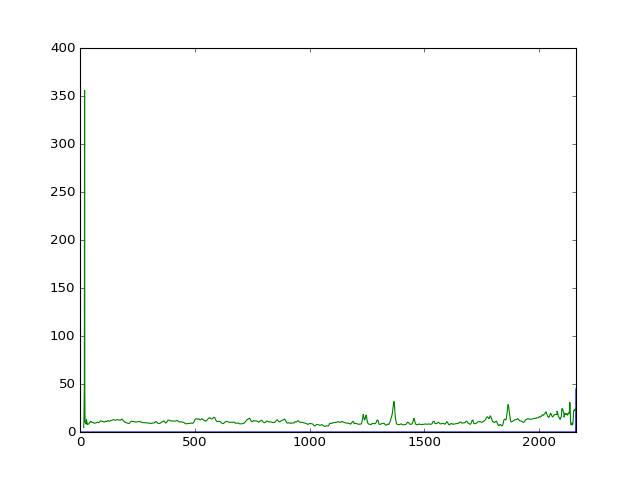

In [10]:
df.sn_top.plot()
df.ild.plot()